# NRPy+'s Finite Difference Interface

### NRPy+ Source Code for this module: [finite_difference.py](../edit/finite_difference.py)

### Finite difference derivatives

Suppose we have a *uniform* numerical grid in one dimension; say, the Cartesian $x$ direction. Since the grid is uniform, the spacing between successive grid points is $\Delta x$, and the position of the $i$th point is given by

$$x_i = x_0 + i \Delta x.$$

Then, given a function $u(x)$ on this uniform grid, we will adopt the notation

$$u(x_i) = u_i.$$

We wish to approximate derivatives of $u_i$ at some nearby point (first we will consider derivatives at $x_i$ itself) using [finite difference](https://en.wikipedia.org/wiki/Finite_difference). (FD) techniques. 

FD techniques are usually equivalent to first finding the unique $N$th degree polynomial that passes through $N+1$ sampled points of our function ($u$) in the neighborhood of where we wish to find the derivative. Then, provided $u$ is smooth and properly-sampled, the $M$th derivative of the polynomial (where $M\le N-1$; *Exercise: Justify this inequality*) is an approximate $M$th derivative of $u$ called the *$M$th-order finite difference derivative*. The approximation error generally decreases as the polynomial degree or sampling density increases.

Finite difference derivatives are written in the form
$$u^{(n)}(x_i)_{\text{FD}} = \sum_{j} u_j a_j,$$
where the $a_j$'s are known as *finite difference coefficients*. For a given finite difference representation, the set of $a_j$'s are unique.

There are many ways to compute finite difference coefficients $a_j$, though perhaps the most popular involves Taylor series expansions about sampled points near the point where we wish to evaluate the derivative.

### Recommended: Learn more about the algorithm NRPy+ adopts to automatically compute finite difference derivatives: ([How NRPy+ Computes Finite Difference Coefficients](Tutorial-How_NRPy_Computes_Finite_Difference_Coeffs.ipynb))

The finite_difference NRPy+ module contains one parameter:
* **FD_CENTDERIVS_ORDER**: An integer indicating the requested finite difference *accuracy* order (*not* the order of the derivative) , where FD_CENTDERIVS_ORDER = \[the size of the finite difference stencil in each direction, plus one\]. 

The finite_difference NRPy+ module contains two core functions: **compute_fdcoeffs_fdstencl** and **FD_outputC()**. The first is a low-level function normally called only by FD_outputC(), which computes and outputs finite difference coefficients and the numerical grid indices (stencil) corresponding to each coefficient:

### **compute_fdcoeffs_fdstencl(derivstring,FDORDER=-1)**:
* Output nonzero finite difference coefficients and corresponding numerical stencil as lists, using as inputs:
    * **derivstring**: indicates the precise type and direction derivative desired:
        * **Centered derivatives**, where the center of the finite difference stencil corresponds to the point where the derivative is desired:
            * For a first-order derivative, set derivstring to "D"+"dirn", where "dirn" is an integer denoting direction. For a second-order derivative, set derivstring to "DD"+"dirn1"+"dirn2", where "dirn1" and "dirn2" are integers denoting the direction of each derivative. Currently only $1 \le N \le 2$ supported (extension to higher-order derivatives is straightforward). Examples in 3D Cartesian coordinates (x,y,z):
                * the derivative operator $\partial_x^2$ corresponds to derivstring = "DD00"
                * the derivative operator $\partial_x \partial_y$ corresponds to derivstring = "DD01"
                * the derivative operator $\partial_z$ corresponds to derivstring = "D2"
        * **Up- or downwinded derivatives**, where the center of the finite difference stencil is *one gridpoint* up or down from where the derivative is requested.
            * Set derivstring to "upD"+"dirn" or "dnD"+"dirn", where "dirn" is an integer denoting direction. Example in 3D Cartesian coordinates (x,y,z):
                * the upwinded derivative operator $\partial_x$ corresponds to derivstring = "dupD0"
        * **Kreiss-Oliger dissipation derivatives**, where the center of the finite difference stencil corresponds to the point where the dissipation will be applied.
            * Set derivstring to "dKOD"+"dirn", where "dirn" is an integer denoting direction. Example in 3D Cartesian coordinates (x,y,z):
                * the Kreiss-Oliger derivative operator $\partial_z^\text{KO}$ corresponds to derivstring = "dKOD2"
    * **FDORDER**: an *optional* parameter that, if set to a positive even integer, overrides FD_CENTDERIVS_ORDER

Within NRPy+, compute_fdcoeffs_fdstencl() is only called from FD_outputC(). Regardless, this function provides a nice interface for evaluating finite difference coefficients, as shown below:

In [1]:
# Import the finite difference module
import finite_difference as fin

# 
fdcoeffs, fdstencl = fin.compute_fdcoeffs_fdstencl("dD0",4)
print(fdcoeffs)
print(fdstencl)

[1/12, -2/3, 2/3, -1/12]
[[-2, 0, 0, 0], [-1, 0, 0, 0], [1, 0, 0, 0], [2, 0, 0, 0]]


Interpreting the output, notice first that $\texttt{fdstencl}$ is a list of coordinate indices, where up to 4 dimension indices are supported (higher dimensions are possible and can be straightforwardly added, though be warned about [The Curse of Dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality)).

Thus NRPy+ found that for some function $u$, the fourth-order accurate finite difference operator is given by

$$[\partial_x u]_\text{FD4} = \frac{1}{\Delta x} \left[ \frac{1}{12} \left(u_{i0-2,i1,i2,i3} - u_{i0+2,i1,i2,i3}\right) + \frac{2}{3} \left(-u_{i0-1,i1,i2,i3} + u_{i0+1,i1,i2,i3}\right)\right]$$

Notice also that multiplying by the appropriate power of $\frac{1}{\Delta x}$ term is up to the user of this function.

In addition, if the gridfunction $u$ exists on a grid that is less than four (spatial) dimensions, it is up to the user to truncate the additional index information.

#### Exercise: Using compute_fdcoeffs_fdstencl(), write the necessary loops to output the finite difference coefficient tables in the Wikipedia article on [finite difference coefficients](https://en.wikipedia.org/wiki/Finite_difference_coefficients), for up to second-order derivatives (i.e., up to $\partial_i^2$), and for upwinded derivatives up to second-order accuracy.

### **FD_outputC(filename,sympyexpr_list)**:

C codes that evaluate expressions with finite difference derivatives on numerical grids generally consist of three  components, all existing within a loop over "interior" gridpoints; at a given gridpoint, the code must
1. Read gridfunctions from memory at all points needed to evaluate the finite difference derivatives or the gridfunctions themselves.
2. Perform arithmetic, including computation of finite difference stencils.
3. Write the output from the arithmetic to other gridfunctions.

To minimize cache misses and maximize potential compiler optimizations, it is generally recommended to segregate the above three steps. FD_outputC() first analyzes the input expressions, searching for derivatives of gridfunctions. The search is very easy, as NRPy+ requires a very specific syntax for derivatives: 
* gf_dD0 denotes the first derivative of gridfunction "gf" in direction zero.
* gf_dupD0 denotes the upwinded first derivative of gridfunction "gf" in direction zero.
* gf_ddnD0 denotes the downwinded first derivative of gridfunction "gf" in direction zero.
* gf_dKOD2 denotes the Kreiss-Oliger dissipation operator of gridfunction "gf" in direction two.
Each time FD_outputC() finds a derivative (including references to the gridfunction directly \["zeroth"-order derivatives\]) in this way, it calls compute_fdcoeffs_fdstencl() to record the specific locations in memory from which the underlying gridfunction must be read to evaluate the appropriate finite difference derivative.

FD_outputC() then orders this list of points for all gridfunctions and points in memory, optimizing memory reads based on how the gridfunctions are stored in memory (set via parameter MemAllocStyle in the NRPy+ grid module). It then completes step 1. 

For step 2, FD_outputC() exports all of the finite difference expressions, as well as the original expressions input into the function, to outputC() to generate the optimized C code. Step 3 follows trivally from just being careful with the bookkeeping in the above steps.

**FD_outputC() takes two arguments:
* **filename**: Set to "stdout" to print to screen. Otherwise specify a filename.
* **sympyexpr_list**: A single named tuple or list of named tuples of type "lhrh", where the lhrh type refers to the simple structure:
    * **lhrh(left-hand side of equation, right-hand side of the equation)**

Time for an example: let's compute $$\texttt{output} = \partial_0^2 \phi$$
for gridfunctions $\texttt{output}$ and $\texttt{phi}=\phi$:

In [2]:
import sympy as sp
from outputC import *
import grid as gri
import indexedexp as ixp
import finite_difference as fin

# Set the spatial dimension to 1
par.set_paramsvals_value("grid::DIM = 1")

# Register the input gridfunction "phi" and the gridfunction to which data are output, "output":
phi, output = gri.register_gridfunctions("AUX",["phi","output"])

# Declare phi_dD as a rank-1 indexed expression: phi_dD[i] = \partial_i phi
phi_dDD = ixp.declarerank2("phi_dDD","nosym")

# Set output to \partial_0^2 phi
output = phi_dDD[0][0]

# Output to the screen the core C code for evaluating the finite difference derivative
fin.FD_outputC("stdout",lhrh(lhs=gri.gfaccess("out_gf","output"),rhs=output))
# Output to file the same
fin.FD_outputC("finite_diff_tutorial-second_deriv.h",lhrh(lhs=gri.gfaccess("out_gfs","output"),rhs=output))

/*
 *  Original SymPy expressions:
 *  "[const double phi_dDD00 = invdx0**2*(-5*phi/2 + 4*phi_i0m1/3 - phi_i0m2/12 + 4*phi_i0p1/3 - phi_i0p2/12),
 *    out_gf[IDX2(OUTPUTGF, i0)] = phi_dDD00]"
 */
{
   const double phi_i0m2 = in_gfs[IDX2(PHIGF, i0-2)];
   const double phi_i0m1 = in_gfs[IDX2(PHIGF, i0-1)];
   const double phi = in_gfs[IDX2(PHIGF, i0)];
   const double phi_i0p1 = in_gfs[IDX2(PHIGF, i0+1)];
   const double phi_i0p2 = in_gfs[IDX2(PHIGF, i0+2)];
   const double phi_dDD00 = pow(invdx0, 2)*(-5.0/2.0*phi + (4.0/3.0)*phi_i0m1 - 1.0/12.0*phi_i0m2 + (4.0/3.0)*phi_i0p1 - 1.0/12.0*phi_i0p2);
   out_gf[IDX2(OUTPUTGF, i0)] = phi_dDD00;
}
Wrote to file "finite_diff_tutorial-second_deriv.h"


## (In progress) Generating the rest of the C code

The gridfunction PHIGF samples some function $\phi(x)$ at discrete uniform points in $x$, labeled $x_i$ at all points $i\in [0,N]$, so that 
$$\phi(x_i) = \phi_{i}=\text{in_gfs[IDX2(PHIGF, i)]}.$$ 
For a *uniformly* sampled function with constant grid spacing (sample rate) $\Delta x$, $x_i$ is defined as $x_i = x_0 + i \Delta x$.

In the above code, the variable $\texttt{invdx0}$ is defined in terms of the uniform gridspacing $\Delta x$ as $\texttt{invdx0} = \frac{1}{\Delta x}$. (*Aside: Why do we choose to multiply by $1/\Delta x$ instead of dividing the expression by $\Delta x$, which would seem much more straightforward? Answer: as discussed in the [first part of the tutorial](Tutorial-Coutput__Parameter_Interface.ipynb), division of floating-point numbers on modern CPUs is far more expensive than multiplication, usually by a factor of ~3 or more.*)

In [3]:
%%writefile finite_difference_test.c

// Part P1: Import needed header files
#include "stdio.h"  // Provides printf()
#include "stdlib.h" // Provides malloc() and free()
#include "math.h"   // Provides sin()

// Part P2: Declare the IDX2(gf,i) macro, which enables us to store 2-dimensions of
//          data in a 1D array. In this case, consecutive values of "i" 
//          ("gf" held to a fixed value) are consecutive in memory, where 
//          consecutive values of "gf" (fixing "i") are separated by N elements in
//          memory.
#define IDX2(gf, i) ( (i) + Npts_in_stencil * (gf) )

// Part P3: Set PHIGF and OUTPUTGF to macros
#define PHIGF    0
#define OUTPUTGF 1

// Part P4: Import code generated by NRPy+ to compute f''(x)
//          as a finite difference derivative.
void f_dDD_FD(double *in_gfs,double *out_gfs,const int i0,const int Npts_in_stencil,const double invdx0)  {
#include "finite_diff_tutorial-second_deriv.h"
}

// Part P5: Define the function we wish to differentiate, as well as its exact second derivative:
double f(const double x)           { return  sin(x); } // f(x)
double f_dDD_exact(const double x) { return -sin(x); } // f''(x)

// Part P6: Define x_i = (x_0 + i*Delta_x)
double x_i(const double x_0,const int i,const double Delta_x) { 
    return (x_0 + (double)i*Delta_x);
}


// main() function
int main(int argc,char *argv[]) {
    // Step 1: Set some needed constants
    const int Npts_in_stencil = 5; // Equal to the finite difference order, plus one.  '+str(par.parval_from_str("finite_difference::FD_CENTDERIVS_ORDER"))+'+1;
    const double PI = 3.14159265358979323846264338327950288; // The scale over which the sine function varies.
    const double x_eval = PI/4.0; // x_0 = desired x at which we wish to compute f(x)

    // Step 2: Allocate space for two gridfunctions
    double *in_gfs = (double *)malloc(sizeof(double)*Npts_in_stencil*2);
    
    // Step 3: Loop over grid spacings
    for(double Delta_x = 1e-5*(2*PI);Delta_x<=1e-2*(2*PI);Delta_x*=2) {

        // Step 3a: x_eval is the center point of the finite differencing stencil,
        //          thus x_0 = x_eval - 2*dx for fourth-order-accurate first & second finite difference derivs,
        //          and  x_0 = x_eval - 3*dx for sixth-order-accurate first & second finite difference derivs, etc.
        //          In general, for the integer Npts_in_stencil, we have
        //          x_0 = x_eval - (double)(Npts_in_stencil/2)*Delta_x,
        //          where we rely upon integer arithmetic (which always rounds down) to ensure 
        //          Npts_in_stencil/2 = 5/2 = 2 for fourth-order-accurate first & second finite difference derivs:
        const double x_0 = x_eval - (double)(Npts_in_stencil/2)*Delta_x;

        // Step 3b: Set \phi=PHIGF to be f(x) as defined in the 
        //          f(const double x) function above, where x_i = stencil_start_x + i*Delta_x:
        for(int ii=0;ii<Npts_in_stencil;ii++) {
            in_gfs[IDX2(PHIGF, ii)] = f(x_i(x_0,ii,Delta_x));
        }
        
        // Step 3c: Set invdx0, which is needed by the NRPy+-generated "finite_diff_tutorial-second_deriv.h"
        const double invdx0 = 1.0/Delta_x;

        // Step 3d: Evaluate the finite-difference second derivative of f(x):
        const int i0 = Npts_in_stencil/2; // The derivative is evaluated at the center of the stencil.
        f_dDD_FD(in_gfs,in_gfs,i0,Npts_in_stencil,invdx0);
        double FD = in_gfs[IDX2(OUTPUTGF,i0)];

        // Step 3e: Evaluate f''(x) using the exact expression:
        double EX = f_dDD_exact(x_0);
        
        // Step 3f: Print log_10(\Delta x) and log_10([relative error])
        printf("%e\t%.15e\n",log10(Delta_x),log10(fabs((EX-FD)/(EX))));
    }
    
    // Step 4: Free the allocated memory for the gridfunctions.
    free(in_gfs);

    return 0;
}

Overwriting finite_difference_test.c


In [4]:
!gcc -std=gnu99 -O2 finite_difference_test.c -o finite_difference_test -lm && ./finite_difference_test > data.txt

Using matplotlib backend: TkAgg


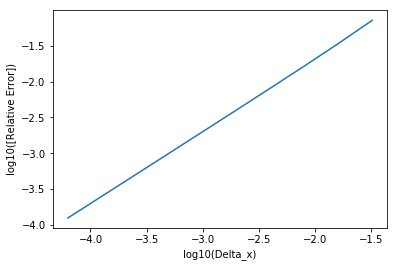

In [5]:
%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# from https://stackoverflow.com/questions/12311767/how-to-plot-files-with-numpy
plt.plotfile('data.txt', delimiter = '\t', cols=(0,1), names=('log10(Delta_x)','log10([Relative Error])'))